In [ ]:
import math
import os
import sys
sys.path.append("..")
import random
import numpy as np
import torch
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torchvision.transforms as T
from source.cliploss import Loss
from source.beziercurve import CurveSet
from source.diffrasterizer import rasterize_spheres
from source.imagesampler import ImageSampler
from source.initalizer import random_short_lines, initialize_saliency_curves
from source.trainer import Trainer
from types import SimpleNamespace
from source.saliency import DinoSaliency
torch.random.manual_seed(0)

In [ ]:
#Important Hyperparameters
batch_size = 1
epochs = 400
inner_steps = 100
thickness = 0.02
learning_rate = 0.001
data_name = 'duck'
clip_conv_layer_weights=[0, 0, 1.0, 1.0, 0.0]
clip_fc_loss_weight=0.1
clip_weight=1.0
clip_conv_loss=1.0
n_curves = 20
radius   = 0.7    # how far out to place each line from center
length   = 0.01    # how long each line is
overlap = 0.6

In [ ]:
# --- Settings ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
width, height = 224, 224
save_dir = Path('training_frames')
save_dir.mkdir(exist_ok=True)
# --- Prepare data sampler for a single scene ---
transforms_json = '../data/{}/transforms_train.json'.format(data_name)
image_dir = '../data/{}/rgb'.format(data_name)
sampler = ImageSampler(
    transforms_json=transforms_json,
    image_dir=image_dir,
    width=width,
    height=height,
    total_iters=0,  # unused in random sampling
    device=device,
)

# --- Prepare loss and rasterizer ---
args = SimpleNamespace(
    device=device,
    percep_loss='none',
    train_with_clip=True,
    clip_weight=clip_weight,
    start_clip=0,
    clip_conv_loss=clip_conv_loss,
    clip_fc_loss_weight=clip_fc_loss_weight,
    clip_text_guide=0.0,
    num_aug_clip=4,
    augemntations=['affine'],
    include_target_in_aug=False,
    augment_both=False,
    clip_model_name='ViT-B/32',
    clip_conv_loss_type='L2',
    clip_conv_layer_weights=clip_conv_layer_weights
)
criterion = Loss(args).to(device)
rasterizer = torch.compile(rasterize_spheres)
center_t = torch.tensor(sampler.scene_center,
                        device=device, dtype=torch.float32)
init_pts = random_short_lines(center_t, n_curves, radius, length, device)
sal_model = DinoSaliency(device=device, preprocess_shape=(224, 224))
ctrl_pts = initialize_saliency_curves(
    transforms_json='../data/duck/transforms_train.json',
    image_dir='../data/duck/rgb',
    width=224, height=224,
    saliency_model=sal_model,
    num_points=100,
    min_distance=5.0,
    high_threshold=0.6,
    radius=0.7,
    length=0.01,
    n_curves=10,
    device=device
)
curve_set = CurveSet(ctrl_pts,
                     thickness=thickness,
                     overlap=overlap,
                     arc_samples=300,
                     device=device).to(device)
optimizer = optim.Adam(curve_set.parameters(), lr=learning_rate)


In [ ]:
trainer = Trainer(
    sampler,
    curve_set,
    rasterizer,
    criterion,
    optimizer,
    batch_size=batch_size,
    inner_steps=inner_steps,
    epochs=epochs,
    width=width,
    height=height,
    save_dir=save_dir,
    display_plots=True
)
means, thicknesses = trainer.train()

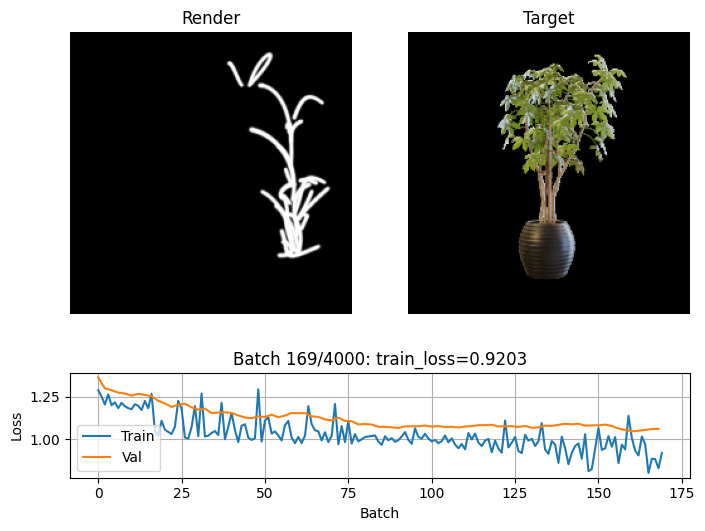

In [ ]:
import math
import os
import sys
sys.path.append("..")
import random
import numpy as np
import torch
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torchvision.transforms as T
from source.cliploss import Loss
from source.beziercurve import CurveSet
from source.diffrasterizer import rasterize_spheres
from source.imagesampler import ImageSampler
from source.initalizer import random_short_lines, initialize_saliency_curves
from source.saliency import DinoSaliency
from source.trainer import Trainer
from types import SimpleNamespace
torch.random.manual_seed(0)

# ————————————————————————————————
# Important Hyperparameters
# ————————————————————————————————
batch_size            = 1
epochs                = 40
inner_steps           = 30
thickness             = 0.01
learning_rate         = 0.001
data_name             = 'ficus'
clip_conv_layer_weights= [0, 0, 1.0, 1.0, 0.0]
clip_fc_loss_weight   = 0.1
clip_weight           = 1.0
clip_conv_loss        = 1.0
n_curves              = 20
radius                = 0.7   # how far out to place each line from center
length                = 0.01  # how long each line is
overlap               = 0.6

# device, image size, output dir
device   = 'cuda' if torch.cuda.is_available() else 'cpu'
width, height = 224, 224
save_dir = Path('training_frames')
save_dir.mkdir(exist_ok=True)

# ————————————————————————————————
# 1) Prepare three samplers: train / val / test
# ————————————————————————————————
base = Path('..') / 'data' / data_name
train_sampler = ImageSampler(
    transforms_json = str(base / 'transforms_train.json'),
    image_dir      = str(base),
    width          = width, 
    height         = height,
    device         = device,
)
val_sampler = ImageSampler(
    transforms_json = str(base / 'transforms_val.json'),
    image_dir      = str(base ),
    width          = width, 
    height         = height,
    device         = device,
)
test_sampler = ImageSampler(
    transforms_json = str(base / 'transforms_test.json'),
    image_dir      = str(base ),
    width          = width, 
    height         = height,
    device         = device,
)

# ————————————————————————————————
# 2) Build loss, rasterizer, curve-set, optimizer
# ————————————————————————————————
args = SimpleNamespace(
    device               = device,
    percep_loss          = 'none',
    train_with_clip      = True,
    clip_weight          = clip_weight,
    start_clip           = 0,
    clip_conv_loss       = clip_conv_loss,
    clip_fc_loss_weight  = clip_fc_loss_weight,
    clip_text_guide      = 0.0,
    num_aug_clip         = 4,
    augemntations        = ['affine'],
    include_target_in_aug= False,
    augment_both         = False,
    clip_model_name      = 'ViT-B/32',
    clip_conv_loss_type  = 'L2',
    clip_conv_layer_weights = clip_conv_layer_weights,
)
criterion   = Loss(args).to(device)
rasterizer  = torch.compile(rasterize_spheres)

# initialize curves around the computed scene center
center_t  = torch.tensor(train_sampler.scene_center, device=device, dtype=torch.float32)
sal_model = DinoSaliency(device=device, preprocess_shape=(224, 224))
ctrl_pts = initialize_saliency_curves(
    transforms_json='../data/ficus/transforms_train.json',
    image_dir='../data/ficus/',
    width=224, height=224,
    saliency_model=sal_model,
    num_points=100,
    min_distance=3.0,
    high_threshold=0.6,
    radius=1,
    length=0.01,
    n_curves=20,
    device=device
)
#init_pts  = random_short_lines(center_t, n_curves, radius, length, device)
curve_set = CurveSet(
    ctrl_pts,
    thickness   = thickness,
    overlap     = overlap,
    arc_samples = 300,
    device      = device
).to(device)

optimizer = optim.Adam(curve_set.parameters(), lr=learning_rate)

# ————————————————————————————————
# 3) Create Trainer and run
# ————————————————————————————————
trainer = Trainer(
    train_sampler = train_sampler,
    val_sampler   = val_sampler,
    test_sampler  = test_sampler,
    curve_set     = curve_set,
    rasterizer    = rasterizer,
    criterion     = criterion,
    optimizer     = optimizer,
    batch_size    = batch_size,
    inner_steps   = inner_steps,
    epochs        = epochs,
    width         = width,
    height        = height,
    save_dir      = str(save_dir),
    eval_interval = 2,       # run val‐loss every 100 batches
    device        = device,
    display_plots = True,      # toggle real‐time images
)

means, thicknesses = trainer.train()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_spheres_matplotlib(
    means: np.ndarray,
    radii: np.ndarray,
    resolution: int = 20,
    alpha: float = 0.6,
    colormap: str = "viridis"
):
    """
    Plot 3D spheres centered at `means` with given `radii`, using Matplotlib.

    Args:
        means      (N,3) numpy array of sphere centers
        radii      (N,)  numpy array of sphere radii
        resolution number of subdivisions in θ,ϕ (higher → smoother)
        alpha      transparency of each sphere
        colormap   name of a matplotlib colormap for coloring spheres
    """
    # parameterize a unit sphere
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    uu, vv = np.meshgrid(u, v)

    fig = plt.figure(figsize=(5, 5),dpi = 600)
    ax = fig.add_subplot(111, projection="3d")

    cmap = plt.get_cmap(colormap)
    N = len(means)

    for i, ((x0, y0, z0), r) in enumerate(zip(means, radii)):
        # compute sphere surface
        x = x0 + r * np.cos(uu) * np.sin(vv)
        y = y0 + r * np.sin(uu) * np.sin(vv)
        z = z0 + r * np.cos(vv)

        # pick a color from the colormap
        color = cmap(i / max(1, N - 1))  # RGBA tuple
        # now build a (res,res,4) array of that color
        fc = np.broadcast_to(np.array(color)[None, None, :], x.shape + (4,))

        ax.plot_surface(
            x, y, z,
            rstride=1, cstride=1,
            facecolors=fc,
            edgecolor='k',    # draw black edges
            linewidth=0.2,    # thin lines
            shade=True,
            alpha=alpha
        )

    # equal aspect ratio
    xyz = np.vstack([means + radii[:, None], means - radii[:, None]])
    x_limits = (xyz[:, 0].min(), xyz[:, 0].max())
    y_limits = (xyz[:, 1].min(), xyz[:, 1].max())
    z_limits = (xyz[:, 2].min(), xyz[:, 2].max())
    max_range = np.array([
        x_limits[1] - x_limits[0],
        y_limits[1] - y_limits[0],
        z_limits[1] - z_limits[0],
    ]).max() / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    #ax.set_xlim(mid_x - max_range, mid_x + max_range)
    #ax.set_ylim(mid_y - max_range, mid_y + max_range)
    #ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.grid(False)

    plt.tight_layout()
    plt.savefig("3D_spheres_plot.png", dpi=600)
    plt.show()

In [ ]:
means_np = trainer.means.detach().cpu().numpy()
radii_np = trainer.thicknesses.detach().cpu().numpy()
plot_spheres_matplotlib(means_np, radii_np*2, resolution=5, alpha=1.0)

In [ ]:
from PIL import Image as PILImage

# Gather and sort saved frames
frame_paths = sorted(save_dir.glob("batch_*.png"))
frames = [PILImage.open(p) for p in frame_paths]

# Save GIF
gif_path = "training_evolution.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=50, loop=0)
print(f"GIF saved to {gif_path}")

In [ ]:
import torch
import math
import numpy as np
from PIL import Image
from source.diffrasterizer import rasterize_spheres

def look_at(eye: torch.Tensor,
            center: torch.Tensor,
            up:    torch.Tensor) -> torch.Tensor:
    """
    Build a world→camera 4×4 view matrix given an eye position, a look-at center, and an up vector.
    """
    z = (eye - center)
    z = z / z.norm(dim=0, keepdim=True)
    x = torch.cross(up, z)
    x = x / x.norm(dim=0, keepdim=True)
    y = torch.cross(z, x)
    R = torch.stack([x, y, z], dim=0)      # 3×3 rotation
    T = -R @ eye.view(3,1)                 # 3×1 translation
    view = torch.eye(4, device=eye.device, dtype=eye.dtype)
    view[:3,:3] = R
    view[:3, 3] = T.squeeze()
    return view

def render_semihelical_gif(
    means:          torch.Tensor,           # (N,3) sphere centers
    radii:          torch.Tensor|float,
    scene_center:   torch.Tensor,           # (3,)
    scene_radius:   float,
    K:              torch.Tensor,           # 3×3 intrinsics
    width:          int,
    height:         int,
    fps:            int     = 15,           # playback frames per second
    rotation_time:  float   = 5.0,          # seconds to go from +X→+Z
    revolutions:    float   = 2.0,          # how many twists around Y-axis
    up:             torch.Tensor = torch.tensor([0.,0,1]),
    output_path:    str     = "semihelical.gif",
):
    """
    Renders a helical camera path on the upper hemisphere of radius `scene_radius`,
    starting at scene_center + (scene_radius,0,0) and ending at
    scene_center + (0,0,scene_radius), twisting `revolutions` times around Y.
    Produces a looping GIF at `fps` for a total duration of rotation_time.
    """
    device = means.device
    center = scene_center.to(device=device, dtype=means.dtype)
    up_vec = up.to(device=device, dtype=means.dtype)

    n_frames   = int(round(fps * rotation_time))
    duration_ms = int(round(1000.0 / fps))

    frames = []
    for i in range(n_frames):
        t   = i / (n_frames - 1)                # from 0 → 1
        phi = t * (math.pi / 2)                # elevation from 0 → 90°
        theta = t * (2 * math.pi * revolutions)  # azimuthal twist

        # Parametric point on hemisphere surface (Z is up)
        x = center[0] + scene_radius * math.cos(phi) * math.cos(theta)
        y = center[1] + scene_radius * math.cos(phi) * math.sin(theta)
        z = center[2] + scene_radius * math.sin(phi)
        cam_pos = torch.tensor([x, y, z], device=device, dtype=means.dtype)

        V = look_at(cam_pos, center, up_vec)  
        alpha = rasterize_spheres(means, radii, V, K, width, height)  # (H,W,1)
        a_np  = (alpha[...,0].detach().cpu().numpy() * 255).astype(np.uint8)
        rgb   = np.stack([a_np]*3, axis=-1)     # gray → RGB
        frames.append(Image.fromarray(rgb))

    # Save as a looping GIF
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration_ms,
        loop=0
    )
    print(f"Saved {output_path}: {n_frames} frames, {fps} FPS, {revolutions} revolutions.")

torch.manual_seed(0)
# --- example usage ---
# Example data
means = trainer.means
N = means.shape[0]
radii = thickness                             # uniform radius
scene_center = torch.tensor(trainer.sampler.scene_center)
scene_radius = 3.0

W, H = 224, 224
K = trainer.sampler.K

render_semihelical_gif(
    means, radii, scene_center, scene_radius,
    K, W, H,
    fps=120,
    rotation_time=4.0,
    revolutions=1.0,
    output_path="semihelical.gif"
)
print(means)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
torch.manual_seed(0)

def plot_scene_with_camera_path(
    means: torch.Tensor,
    radii: torch.Tensor | float,
    scene_center: torch.Tensor,
    scene_radius: float,
    revolutions: float = 3.0,
    n_points: int = 200
):
    """
    Plots spheres at `means` with given `radii` and a helical camera path
    on the upper hemisphere from (scene_radius,0,0) to (0,0,scene_radius).
    
    Parameters:
    - means: (N,3) tensor of sphere centers.
    - radii: either scalar or (N,) tensor of sphere radii.
    - scene_center: (3,) tensor for the center of the hemisphere.
    - scene_radius: radius of the hemisphere on which the camera moves.
    - revolutions: number of full twists around the Y-axis.
    - n_points: number of samples along the path.
    """
    # Convert tensors to numpy
    means_np = means.detach().cpu().numpy()
    if torch.is_tensor(radii):
        radii_np = radii.cpu().numpy()
    else:
        radii_np = np.full(means_np.shape[0], float(radii))
    center = scene_center.cpu().numpy()

    # Parameter t from 0 → 1
    t = np.linspace(0, 1, n_points)
    phi = t * (np.pi / 2)               # elevation angle from 0 to 90°
    theta = t * (2 * np.pi * revolutions)  # azimuthal twist

    # Camera positions on hemisphere
    cam_x = center[0] + scene_radius * np.cos(phi) * np.cos(theta)
    cam_y = center[1] + scene_radius * np.cos(phi) * np.sin(theta)
    cam_z = center[2] + scene_radius * np.sin(phi)

    # Set up 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    for center_pt, r in zip(means_np, radii_np):
        x_s = center_pt[0] + r * np.outer(np.cos(u), np.sin(v))
        y_s = center_pt[1] + r * np.outer(np.sin(u), np.sin(v))
        z_s = center_pt[2] + r * np.outer(np.ones_like(u), np.cos(v))
        ax.plot_surface(x_s, y_s, z_s, color='cyan', alpha=0.3, linewidth=0)

    # Plot camera path
    ax.plot(cam_x, cam_y, cam_z, 'r-', linewidth=2, label='Camera Path')
    ax.scatter(cam_x[0], cam_y[0], cam_z[0], color='green', s=50, label='Start')
    ax.scatter(cam_x[-1], cam_y[-1], cam_z[-1], color='black', s=50, label='End')
    
    # Plot scene center
    ax.scatter(center[0], center[1], center[2], color='magenta', s=80, label='Scene Center')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scene with Spheres and Camera Path')
    plt.tight_layout()
    plt.show()


# --- Example usage ---
    # Example data
means = trainer.means
N = means.shape[0]
radii = thickness                             # uniform radius
scene_center = torch.tensor(trainer.sampler.scene_center)
scene_radius = 3.0

W, H = 224, 224
K = trainer.sampler.K

plot_scene_with_camera_path(
    means, radii, scene_center, scene_radius,
    revolutions=1.0, n_points=300
)
print(means)

In [ ]:
trainer.sampler.K